# FixMatch


In [1]:
# !pip install kornia torchvision torchmetrics torchview tqdm

In [2]:
# deep learning
import torch
import torch.nn as nn
from torch.distributions.transforms import LowerCholeskyTransform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader, Dataset

# vizualisation
import torchsummary

# transforms
import torchvision.transforms as T
import kornia.augmentation as K

# metrics
from torchmetrics import Accuracy

# torchvision
import torchvision
import torchvision.transforms as transforms

# plotting
import matplotlib.pyplot as plt
from torchview import draw_graph
from IPython.display import display
from IPython.core.display import SVG, HTML
from tqdm import tqdm

# typing
from typing import Callable, Optional

In [3]:
# Set device
if float(torch.__version__.split(".")[1]) >= 13 and torch.has_mps:
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device = torch.device("mps")

print(device)

mps


In [4]:
IMG_SHAPE = (3, 32, 32)
# See Table 4
TAU = 0.90 # 0.95
LAMBDA_U = 1
MU = 7
BATCH_SIZE = 128 # B
LR = 0.03
BETA = 0.9
WEIGHT_DECAY = 0.001

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=T.ToTensor())

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=T.ToTensor())
                                        
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=4)                            
                                       
testloader = DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Utils function

In [6]:
def plot_images(images: torch.Tensor, true_labels: torch.Tensor, predicted_labels: torch.Tensor) -> plt.Figure: # type: ignore
    assert images.shape[0] >= 16, "Not enough images to plot"
    assert images.shape[0] == true_labels.shape[0] == predicted_labels.shape[0], "Number of images and labels do not match"
    fig, axes = plt.subplots(4, 4, figsize=(10,10))
    axes = axes.ravel() # type: ignore

    for i in range(16):
        axes[i].imshow(images[i].cpu().numpy().transpose(1, 2, 0))
        axes[i].set_title(f"True: {classes[true_labels[i]]}\nPredicted: {classes[predicted_labels[i]]}")
        axes[i].axis('off')
        fig.subplots_adjust(hspace=0.5)

    return fig

def plot_transform(images: torch.Tensor, transform: Callable[[torch.Tensor], torch.Tensor], transform_name: Optional[str] = None) -> plt.Figure:     # type: ignore
    assert images.shape[0] >= 4, "Not enough images to plot"
    fig, axes = plt.subplots(2, 4, figsize=(10,5))
    images = images[:4]
    images_transformed = transform(images)
    transform_name = transform_name if transform_name is not None else ''

    for i in range(4):
        axes[0][i].imshow(images[i].cpu().numpy().transpose(1, 2, 0))
        axes[0][i].set_title(f"Original")
        axes[0][i].axis('off')

        axes[1][i].imshow(images_transformed[i].cpu().numpy().transpose(1, 2, 0))
        axes[1][i].set_title(f"Transformed {transform_name}")
        axes[1][i].axis('off')

    return fig

## RandAugment

Pour implémenter l'augmentation forte dans FixMatch, vous aurez besoin d'une politique d'augmentation de données apprise par renforcement. La méthode RandAugment a été implémentée dans la bibliothèque imgaug, voici comment l'utiliser


In [7]:
# implementation in PyTorch of a simple CNN

class ConvNN(nn.Module):
    """
    Simple CNN for CIFAR10
    """
    
    def __init__(self):
        super().__init__()
        self.conv_32 = nn.Conv2d(3, 32, kernel_size=3, padding='same')
        self.conv_64 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.conv_96 = nn.Conv2d(64, 96, kernel_size=3, padding='same')
        self.conv_128 = nn.Conv2d(96, 128, kernel_size=3, padding='same')
        self.fc_512 = nn.Linear(512, 512)
        self.fc_10 = nn.Linear(512, 10)
        self.max_pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_32(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_64(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_96(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_128(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.flatten(x)
        x = self.fc_512(x)
        x = self.relu(x)
        x = self.fc_10(x)
        return x

In [8]:
model_graph = draw_graph(ConvNN(), input_size=[(BATCH_SIZE, *IMG_SHAPE)], graph_name='./figures/model', graph_dir="LR", device='cpu', expand_nested=True, save_graph=True)

display(
    HTML("<h2>Model</h2>"),
    SVG(model_graph.visual_graph._repr_image_svg_xml()),
)

In [9]:
EPOCHS = 5

model = ConvNN().to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA)
scheduler = None
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
criterion = nn.CrossEntropyLoss().to(device)
accuracy = Accuracy(task="multiclass", num_classes=10).to(device)

for epoch in range(EPOCHS):
    # Training
    model.train()
    epoch_loss = 0.0
    for (images, labels) in (pbar := tqdm(trainloader, desc=f"Epoch {epoch: >5}")) :
        # extract mini batch
        images, labels = images.to(device), labels.to(device)
        # forward pass
        outputs = model.forward(images)
        label_pred = outputs.argmax(dim=1)
        loss = criterion.forward(outputs, labels)
        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # update weights
        optimizer.step()
        
        # update metrics
        epoch_loss += loss.item()*images.size(0)/len(trainloader)
        # print statistics
        pbar.set_postfix(
            {
                "train_batch_loss": f"{loss.item():.2f}",
                "train_epoch_loss": f"{epoch_loss:.2f}",
                "train_accuracy": f"{accuracy(labels.cpu(), label_pred.cpu()):.2f}",
                "lr": f"{optimizer.param_groups[0]['lr']:.3f}",
            }
        )
    if scheduler is not None:
        scheduler.step()

    # Validation using test
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0.0
        for (images_val, label_val) in (pbar := tqdm(testloader, desc=f"Epoch val {epoch: >1}")):
            images_val, label_val = images_val.to(device), label_val.to(device)
            outputs_val = model.forward(images_val)
            label_pred_val = outputs_val.argmax(dim=1)
            loss_val = criterion.forward(outputs_val, label_val)
            val_epoch_loss += loss_val.item()*images_val.size(0)/len(testloader)
            pbar.set_postfix(
                {
                    "test_batch_loss": f"{loss_val.item():.2f}",
                    "test_epoch_loss": f"{val_epoch_loss:.2f}",
                    "test_accuracy": f"{accuracy(label_val.cpu(), label_pred_val.cpu()):.2f}",
                }
            )

Epoch val 0:   0%|          | 0/79 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/ProjetFixMatch/lib/python3.10/site-packages/torchmetrics/functional/classification/accuracy.py:65: UserWarning: MPS: no support for int64 reduction ops, casting it to int32 (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/ReduceOps.mm:144.)
  tp = tp.sum(dim=0 if multidim_average == "global" else 1)
Epoch val 4: 100%|██████████| 79/79 [00:24<00:00,  3.21it/s, test_loss=0.40, test_epoch_loss=109.92, test_accuracy=0.88]


In [19]:
test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
with torch.no_grad():
    model.eval()
    outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

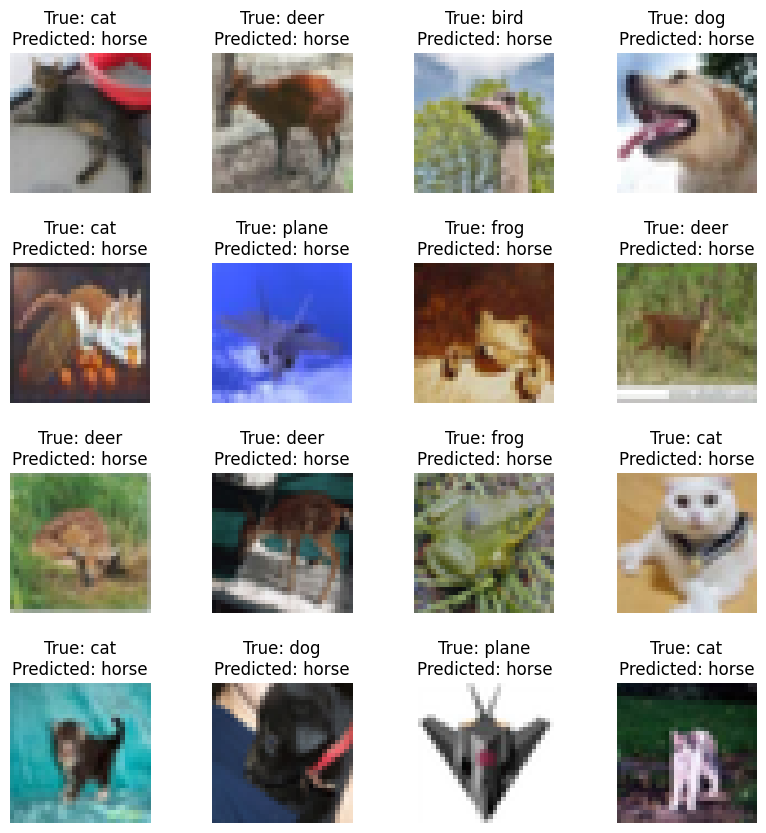

In [20]:
fig1 = plot_images(test_image, test_labels, label_pred_test)

## FixMatch

In [21]:
EPOCHS = 20

# Model
model = ConvNN().to(device)

# Criterion
supervised_criterion = nn.CrossEntropyLoss().to(device)
unsupervised_criterion = nn.CrossEntropyLoss().to(device)

# Metrics
accuracy = Accuracy(task="multiclass", num_classes=10).to(device)

# Optimizer & Scheduler
# optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA)
optimizer = torch.optim.AdamW(model.parameters())
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

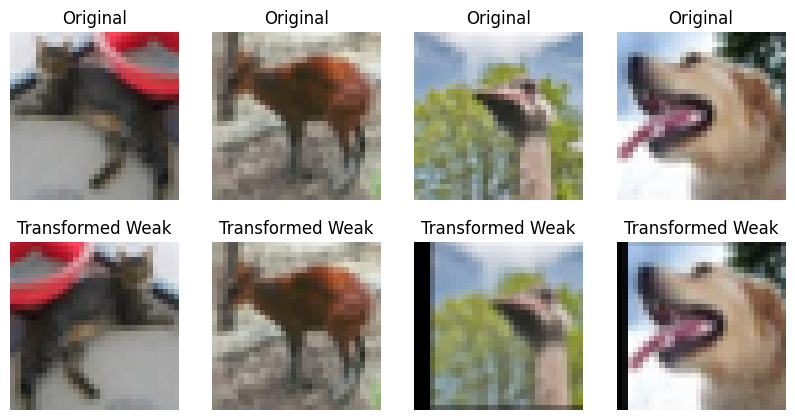

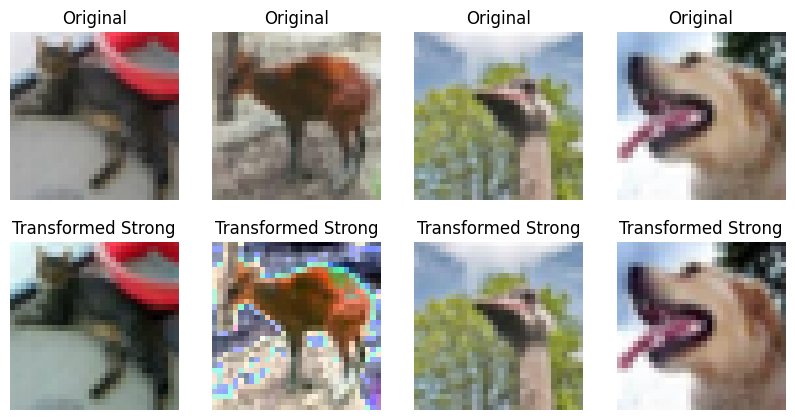

In [24]:
# Transform
weak_transform = K.ImageSequential(
    K.RandomHorizontalFlip(p=0.50), # 50% chance of flipping
    K.RandomAffine(degrees=0, translate=(0.125, 0.125)), # 12.5% chance of vertical of horizontal translation
)

strong_transform = K.ImageSequential(
    K.auto.AutoAugment("cifar10"),
    # K.auto.RandAugment("cifar10"),
    # K.RandomErasing(p=0.25, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0),
)

fig2 = plot_transform(test_image, weak_transform, "Weak")
fig3 = plot_transform(test_image, strong_transform, "Strong")

In [25]:
# Split trainset into train and validation
trainset_sup, trainset_unsup = torch.utils.data.random_split(trainset, [1/(1+MU), MU/(1+MU)])
trainloader_sup = DataLoader(
    trainset_sup, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=4
)
trainloader_unsup = DataLoader(
    trainset_unsup, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=4
)


# Training loop
for epoch in range(EPOCHS):
    # Training
    model.train()
    epoch_loss = 0.0
    trainloader_sup_iter = iter(trainloader_sup)

    for batch_idx in (pbar := tqdm(range(len(trainloader_sup)), desc=f"Epoch {epoch: >5}")):
        # extract mini batch
        images_sup, labels_sup = trainloader_sup_iter.__next__()
        images_sup, labels_sup = images_sup.to(device), labels_sup.to(device)
        
        # Supervised part
        with torch.no_grad():
            images_sup_weak = weak_transform(images_sup)
        logits_weak_pred_sup = model.forward(images_sup_weak)
        proba_weak_pred_sup = torch.nn.functional.softmax(logits_weak_pred_sup, dim=1)
        label_weak_pred_sup = proba_weak_pred_sup.argmax(dim=1)
        loss_weak_sup = supervised_criterion.forward(logits_weak_pred_sup, labels_sup)

        # Unsupervised part
        trainloader_unsup_iter = iter(trainloader_unsup)
        loss_strong_unsup = torch.tensor([0.0], device=device)
        for b_batch_idx in range(MU):
            images_unsup, _ = trainloader_unsup_iter.__next__()
            images_unsup = images_unsup.to(device)

            with torch.no_grad():
                image_unsup_weak = weak_transform(images_unsup)
            logits_weak_pred_unsup = model.forward(image_unsup_weak)
            proba_weak_pred_unsup = torch.nn.functional.softmax(logits_weak_pred_unsup, dim=1)
            label_weak_pred_unsup = proba_weak_pred_unsup.argmax(dim=1)
            confidence_mask = proba_weak_pred_unsup.max(dim=1)[0] > TAU

            if len(confidence_mask) != 0:
                continue
            
            with torch.no_grad():
                image_unsup_strong = strong_transform(images_unsup)
            logits_strong_pred_unsup = model.forward(image_unsup_strong)
            proba_strong_pred_unsup = torch.nn.functional.softmax(logits_strong_pred_unsup, dim=1)
            label_strong_pred_unsup = proba_strong_pred_unsup.argmax(dim=1)

            if len(confidence_mask) != 0:
                loss_strong_unsup_ = unsupervised_criterion.forward(logits_strong_pred_unsup[confidence_mask], label_weak_pred_unsup[confidence_mask])#*(len(confidence_mask)/images_unsup.size(0))
                loss_strong_unsup  = loss_strong_unsup + loss_strong_unsup_
        # logits under the strong against the label under the weak for confident enough predictions

        # Total loss
        loss = loss_weak_sup + LAMBDA_U*loss_strong_unsup

        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # update weights
        optimizer.step()
        
        # update metrics
        epoch_loss += loss.item()*(images_sup.size(0) + images_unsup.size(0))/(len(trainset_sup) + LAMBDA_U*len(trainset_unsup))
        # print statistics
        pbar.set_postfix(
            {
                "train_loss_sup": f"{loss_weak_sup.item():.5f}",
                "confident": f"{confidence_mask.sum().item()}",
                "train_loss_unsup": f"{loss_strong_unsup.item():.5f}",
                "train_loss_total": f"{loss.item():.5f}",
                "epoch_loss": f"{epoch_loss:.5f}",
                "lr": f"{optimizer.param_groups[0]['lr']:.3f}",
            }
        )
    # scheduler.step()
    
    # Validation
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0.0
        for (images_val, label_val) in (pbar := tqdm(testloader, desc=f"Epoch val {epoch: >1}")):
            images_val, label_val = images_val.to(device), label_val.to(device)
            outputs_val = model.forward(images_val)
            label_pred_val = outputs_val.argmax(dim=1)
            loss_val = supervised_criterion.forward(outputs_val, label_val)
            val_epoch_loss += loss_val.item()*images_val.size(0)/len(testloader)
            pbar.set_postfix(
                {
                    "test_loss": f"{loss_val.item():.2f}",
                    "test_epoch_loss": f"{val_epoch_loss:.2f}",
                    "test_accuracy": f"{accuracy(label_val.cpu(), label_pred_val.cpu()):.2f}",
                }
            )

Epoch     0:  22%|██▏       | 11/49 [04:36<16:54, 26.70s/it, train_loss_sup=2.28996, confident=0, train_loss_unsup=0.00000, train_loss_total=2.28996, epoch_loss=0.12947, lr=0.001]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x12ab765f0>
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/ProjetFixMatch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/ProjetFixMatch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/ProjetFixMatch/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/ProjetFixMatch/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wai

In [ ]:
test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

fig1 = plot_images(test_image, test_labels, label_pred_test)

In [ ]:
weak_transform(images_unsup).shape

In [ ]:
weak_transform(image_unsup).shape

In [ ]:
image_unsup.shape

In [ ]:
weak_transform(image_unsup).shape

In [ ]:
x = torch.randn(64, 3, 32, 32)
weak_transform(x).shape

In [ ]:
MU

In [ ]:
trainloader_sup.__len__()*MU

In [ ]:
trainloader_unsup.__len__()

In [ ]:
image_unsup_weak.shape

In [ ]:
image_unsup_weak

In [ ]:
labels_sup

In [ ]:
EPOCHS = 20

model = ConvNN()
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
criterion = nn.CrossEntropyLoss().to(device)
accuracy = Accuracy(task="multiclass", num_classes=10).to(device)


for epoch in range(EPOCHS):
    # Training
    model.train()
    epoch_loss = 0.0
    for (images, labels) in (pbar := tqdm(trainloader, desc=f"Epoch {epoch: >5}")) :
        # extract mini batch
        images, labels = images.to(device), labels.to(device)
        # forward pass
        outputs = model.forward(images)
        label_pred = outputs.argmax(dim=1)
        loss = criterion.forward(outputs, labels)
        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # update weights
        optimizer.step()
        
        # update metrics
        epoch_loss += loss.item()*images.size(0)/len(trainloader)
        # print statistics
        pbar.set_postfix(
            {
                "train_loss": f"{loss.item():.2f}",
                "epoch_loss": f"{epoch_loss:.2f}",
                "lr": f"{optimizer.param_groups[0]['lr']:.3f}",
            }
        )
    # scheduler.step()

    # Validation
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0.0
        for (images_val, label_val) in (pbar := tqdm(validloader, desc=f"Epoch val {epoch: >1}")):
            images_val, label_val = images_val.to(device), label_val.to(device)
            outputs_val = model.forward(images_val)
            label_pred_val = outputs_val.argmax(dim=1)
            loss_val = criterion.forward(outputs_val, label_val)
            val_epoch_loss += loss_val.item()*images_val.size(0)/len(validloader)
            pbar.set_postfix(
                {
                    "val_loss": f"{loss_val.item():.2f}",
                    "val_epoch_loss": f"{val_epoch_loss:.2f}",
                    "accuracy": f"{accuracy(label_val.cpu(), label_pred_val.cpu()):.2f}",
                }
            )